# Seeing Calculations

This notebook does takes a set of images from MCS and
  #1 plots a few basic image diagnostics
  #2 does the centroiding on all the images
  #3 calculates an approximate transformation from the pinhole mask to the image
  #4 applies this to the mask
  #5 registers the centroids in each frame to the mask
  #6 calculates the average of the centroid parameters by position
  #7 calculates the RMS of the spot position (- the average of the frame), compared to the average position
  #8 calculates the translation and scaling for each frame, relative to the mask

# Important Note   

For demonstration purposes, the first few routines are called with a single real image (centroiding through to registering), and the latter ones (averages onwards) use simulated data, as a set of images for the seeing calculation is multiple gigabytes. 

The single image is the same as for the visualization tool. 


In [13]:
#import statements

%matplotlib notebook

#import statements
import vis_plotting as visplot        #plotting routines 
import vis_calculations as viscalc    #calculation routines
import vis_coordinates as viscoords   #routines related to coordinate transforms
import numpy as np
from importlib import reload  #for debugging purposes
import matplotlib.pylab as plt




In [14]:
#set parameters for centroiding

#basic parameters - threshold probably needs to be tuned it should be 
#above the background but below the lowest peak value. 
fwhm=3        
boxsize=9
thresh=2200

#shape parameters for centroiding. If the points are not circular,
#rl and rh may need to be changed; -1, 1 are the values for a circular
#psf. sl and sh should probably not need to be changed

rl=-2.5
rh=1.5
sl=0.05
sh=0.5


# Data IO

At the moment, the code reads in a list of files. This needs to be changed to proper IO with the MCS computer. Intermediate steps are saved to text files, which can be useful for testing. 

In [15]:

#read in list of files (to be replaced by proper IO)
filelist="fileset.dat"

files = [line.rstrip('\n') for line in open(filelist)]
nfiles=len(files)
print("Read "+str(len(files))+" files names.")

#set filenames for saving intermediate steps
tag = "fileset"  # a tag for writing to files or plots
centroidFile=tag+"_centroids.dat"    #file containing centroid


Read 1 files names.


# Sanity Check

As a basic check of data quality, the mean and RMS values of each image are plotted. Note that this is for the pixel values, *not* the spot values. 


MCST_010_001.fits
[797.43053473303917] [72.766695522988414]


<IPython.core.display.Javascript object>


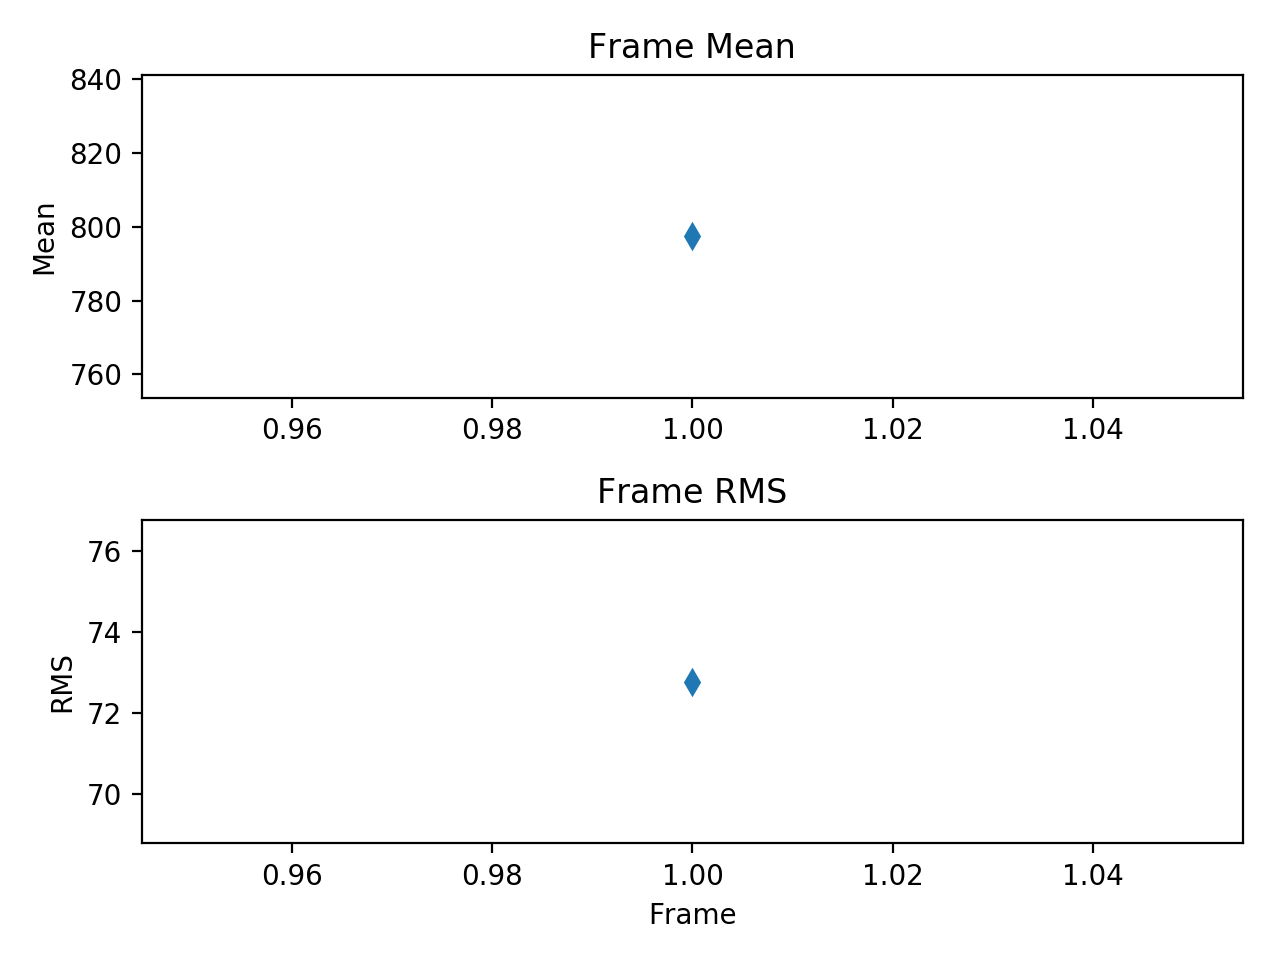

In [16]:
# some basic diagnostic plots
reload(visplot)
visplot.checkPlots(files)


# Centroiding

This is the same as in the visualization tool, but running in a loop to calculate centroids for each frame, and writing the results to a file. 

In [17]:

#do the centroiding. 
reload(viscalc)
xlast,ylast=viscalc.getAllCentroids(files,fwhm,boxsize,thresh,rl,rh,sl,sh,centroidFile)

1 Frames. Centroiding 1, found 3577 centroids, 


# Estimate mask to pixel transformation


In [81]:
#get the approximate transformation (good enough for registration) with 
#the last set of x-y coordinates. This includes the mm-to-pixel transformation. 

reload(viscoords)

xm,ym,xd,yd,theta,scale = viscoords.getApproximateTransform(xlast,ylast)
print("Transform: xd="+str(xd)+" yd="+str(yd)+" theta="+str(theta)+" scale="+str(scale))


Transform: xd=4439.59032911 yd=2892.76723188 theta=1.56220085828 scale=14.6919235189


# Spot Registration

1 frames. Matching 1, 


<IPython.core.display.Javascript object>


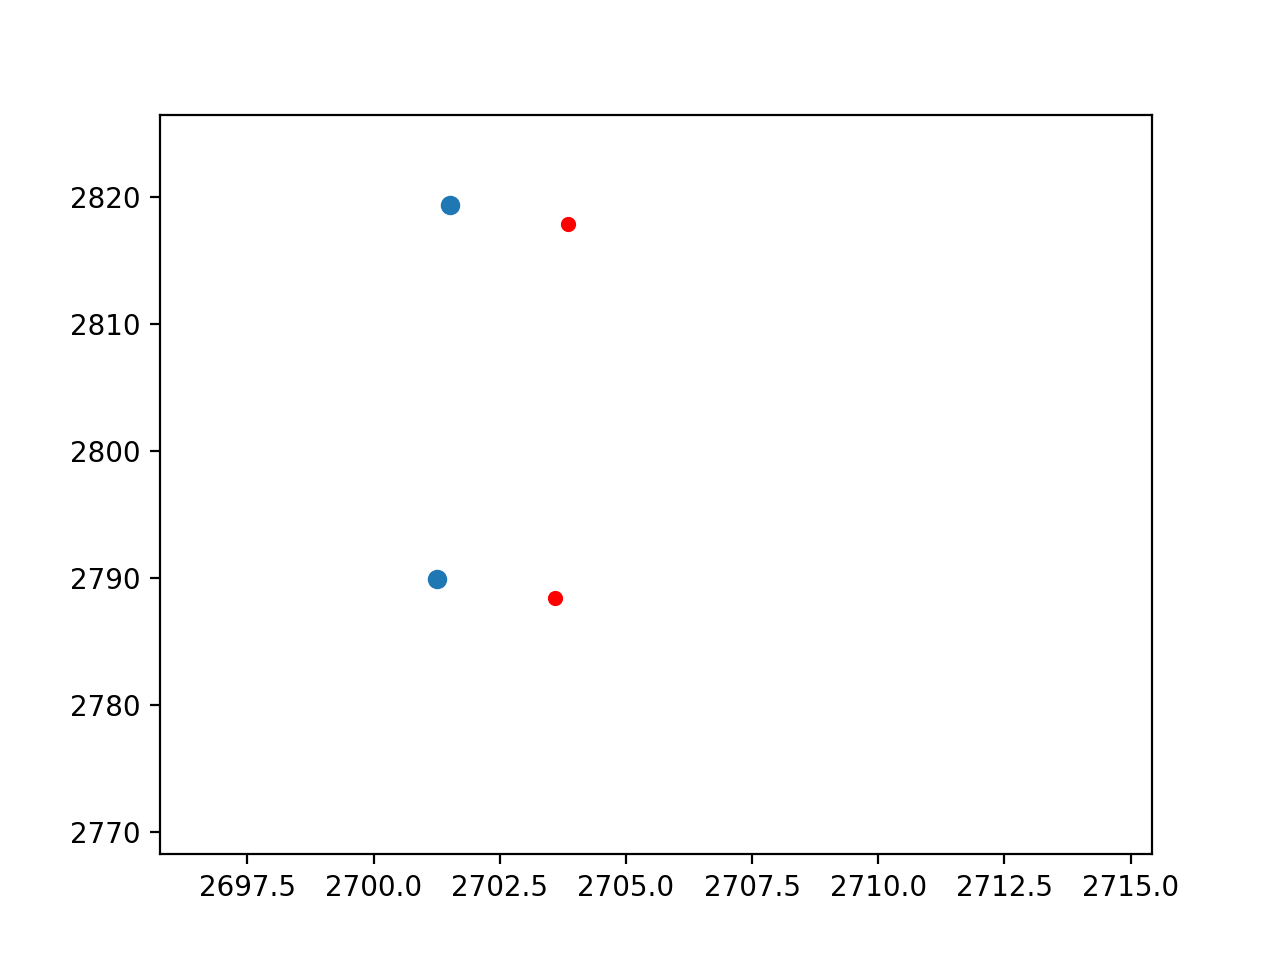

In [19]:
reload(viscoords)

#do the matching. If a point isn't matched to the mask, it will masked via 
#numpy masked arrays.
#The result is a set of data cubes of size npoints x nframes
#display the match for the first frame. 

xArray,yArray,fxArray,fyArray,backArray,peakArray = viscoords.matchAllPoints(centroidFile,xm,ym)
visplot.checkMatched(xArray[:,0],yArray[:,0],xm,ym,tag)


# Simulated Data

For demonstration purposes, as a set of data for seeing calculations is quite large. 


[-1.71079221] [ 0.67338968] [ 14.72352941] [ 0.]
[-1.64395996] [ 4.07403048] [ 14.72352941] [ 0.]
[-1.30177007] [-3.8648267] [ 14.72352941] [ 0.]
[-2.65838877] [-0.46986353] [ 14.72352941] [ 0.]
[-2.48665569] [-5.73140783] [ 14.72352941] [ 0.]
[-1.13732139] [-0.72402634] [ 14.72352941] [ 0.]
[ 0.87474063] [-0.66601353] [ 14.72352941] [ 0.]
[ 1.68832136] [ 0.02539609] [ 14.72352941] [ 0.]
[-2.57889774] [-2.98889437] [ 14.72352941] [ 0.]
[ 0.7906753] [ 0.24827327] [ 14.72352941] [ 0.]
[-2.14648625] [ 1.20508877] [ 14.72352941] [ 0.]
[ 1.4673133] [-1.39860349] [ 14.72352941] [ 0.]
[-1.19819042] [-1.48132655] [ 14.72352941] [ 0.]
[ 0.20979868] [-2.38740212] [ 14.72352941] [ 0.]
[-0.90723431] [-1.7851126] [ 14.72352941] [ 0.]
[ 0.74081981] [-4.85049373] [ 14.72352941] [ 0.]
[ 0.73859245] [-3.68753947] [ 14.72352941] [ 0.]
[-1.11722998] [-0.06217727] [ 14.72352941] [ 0.]
[ 0.42486856] [ 0.59177894] [ 14.72352941] [ 0.]
[ 2.88566133] [ 1.36136622] [ 14.72352941] [ 0.]
[-0.17357736] [ 0.859921

<IPython.core.display.Javascript object>


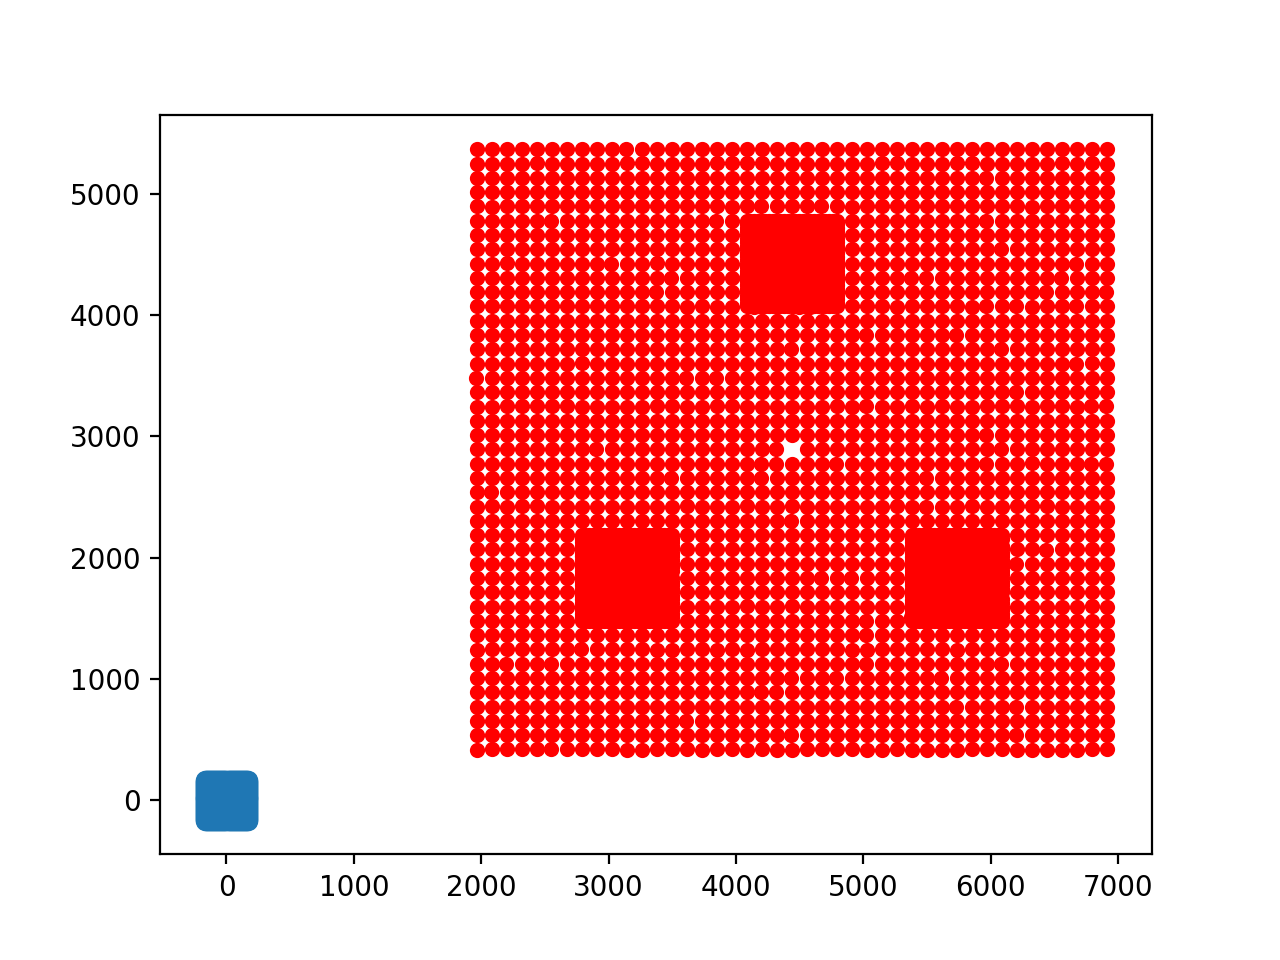

In [74]:
reload(viscalc)
#make fake data for plotting (because 1 set of data is ~3GB)

nframes = 30
avRMS = 0.5
avShift = 2
avScale = 1
avRot = 0
xArray,yArray,fxArray,fyArray,backArray,peakArray, xm, ym = viscalc.makeFakeCentroids(nframes,avRMS,avShift,avRot,avScale)
visplot.checkMatched(xArray[:,0],yArray[:,0],xm,ym,tag)



# Calculate Averages and RMS

In [75]:
reload(viscalc)
#calculate RMS and write to file

xAv,yAv,fxAv,fyAv,peakAv,backAv,rmsVal,nMatch = viscalc.getRMSStats(xArray,yArray,fxArray,fyArray,peakArray,backArray)


-1.34934594262 1.35042432103
-1.26073873736 4.74800781818
-0.937326974931 -3.18233291788
-2.29948353569 0.196996342256
-2.12822256443 -5.06023102754
-0.780524040645 -0.055757861989
1.23739189779 0.0134854944077
2.04910403266 0.669034444239
-2.21858262477 -2.31535563417
1.15240318958 0.912781914108
-1.78413640453 1.86787580562
1.82498382995 -0.715159640645
-0.823246661042 -0.789884133038
0.583914898595 -1.70916824283
-0.527823324763 -1.11463545469
1.11745283221 -4.17448882483
1.09664013617 -3.00437771506
-0.748587948534 0.60998980968
0.805210031718 1.2606872154
3.24557454324 2.05103377101
0.199588665304 1.53899408056
-4.31329265355 2.54945700574
4.64658790063 2.64731111625
1.46465989507 0.171945661774
-0.332830090233 -0.937210358672
-1.35822885715 1.60366375362
0.245210043593 0.764728161051
0.331785160154 0.161689156568
1.21198788677 -2.24944674236
-0.35012458318 2.1899426822


# Plots

#1 Plot of RMS as a function of position
#2 Plot of number of points sucessfully matched (of N frames)
#3 Plot of average FWHM (x) by position
#4 Plot of average FWHM (x) by position

<IPython.core.display.Javascript object>


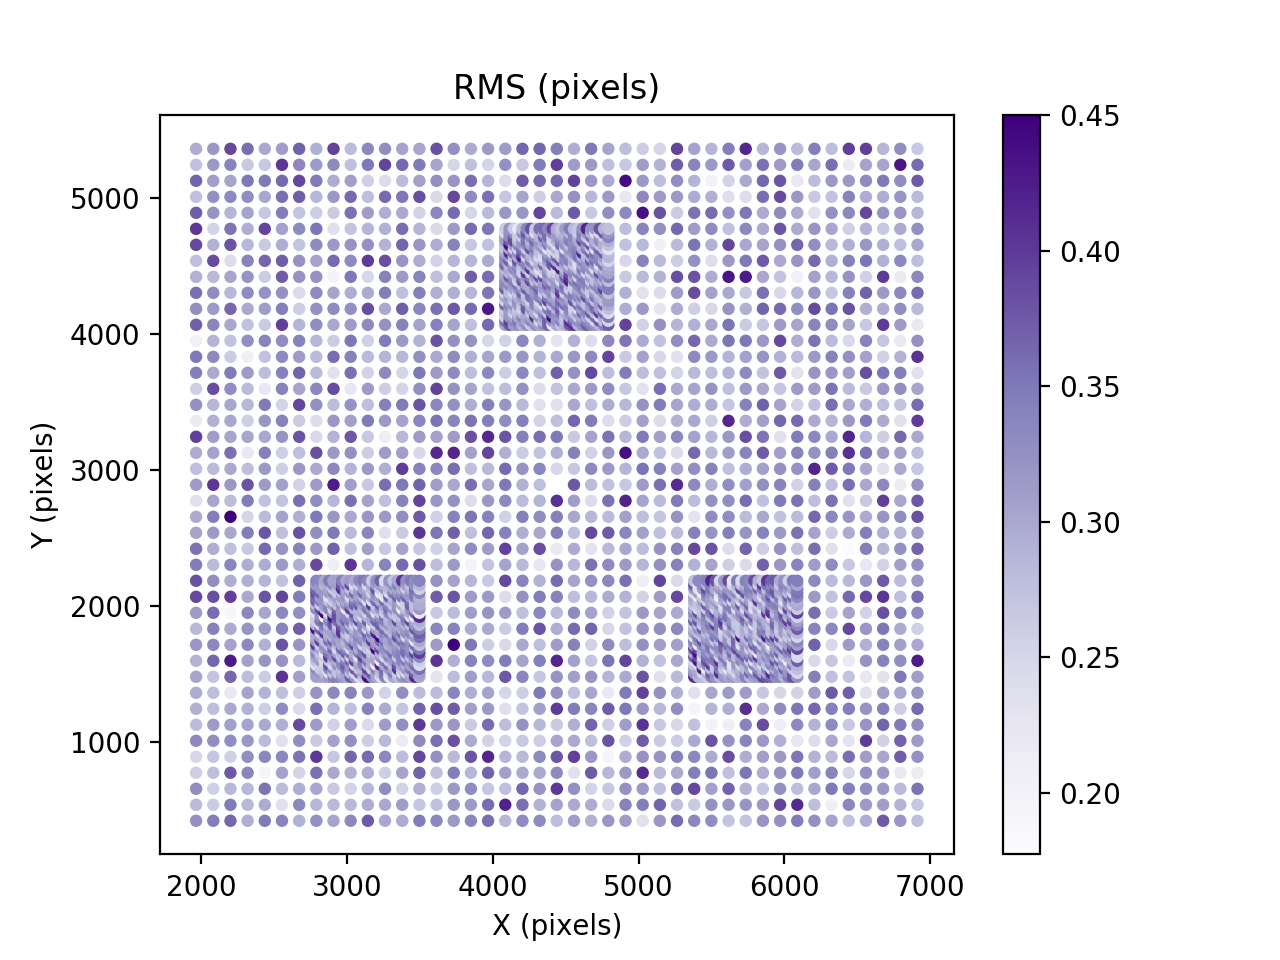

<IPython.core.display.Javascript object>


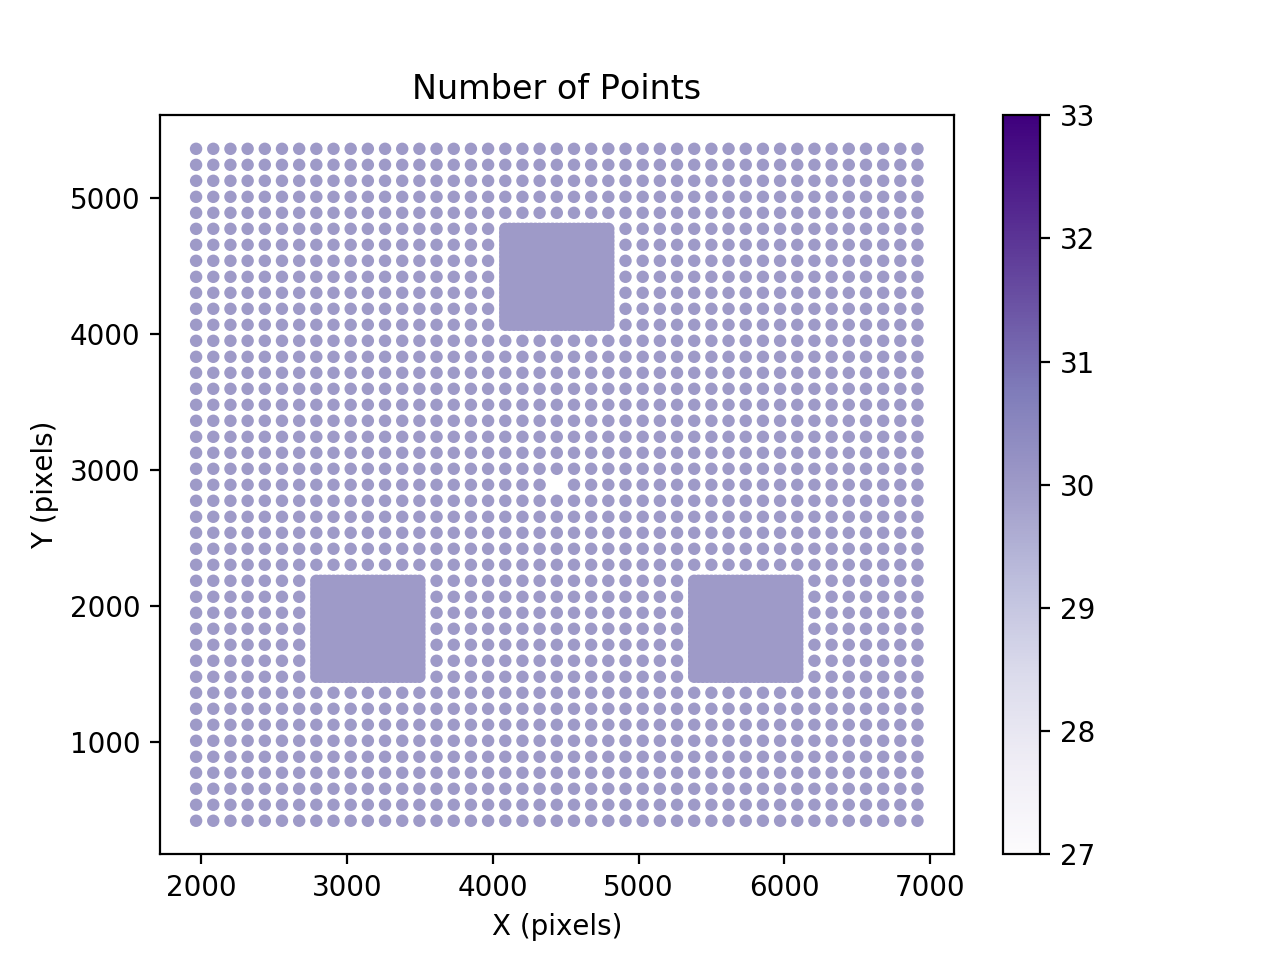

<IPython.core.display.Javascript object>


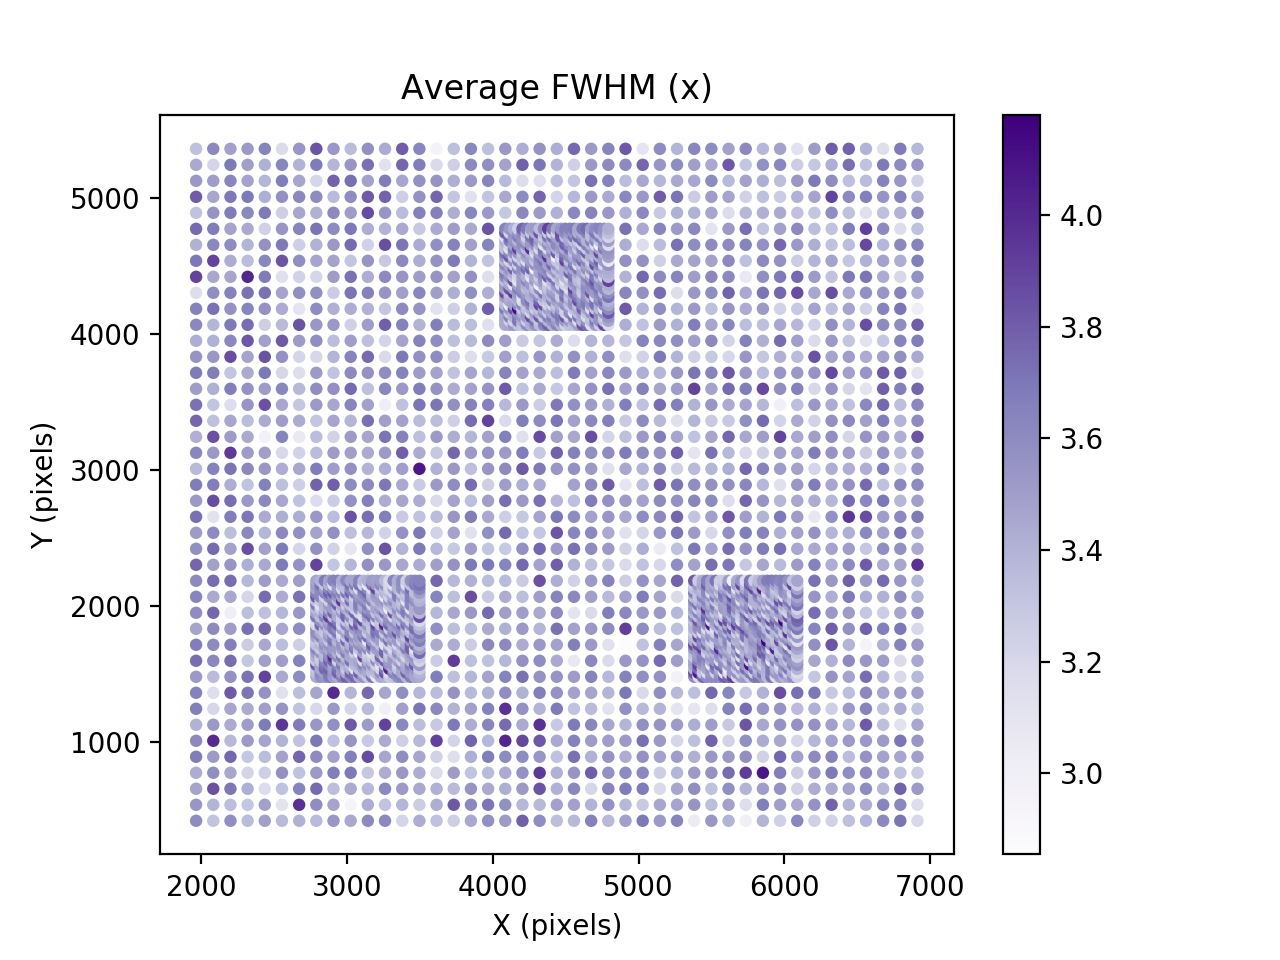

<IPython.core.display.Javascript object>


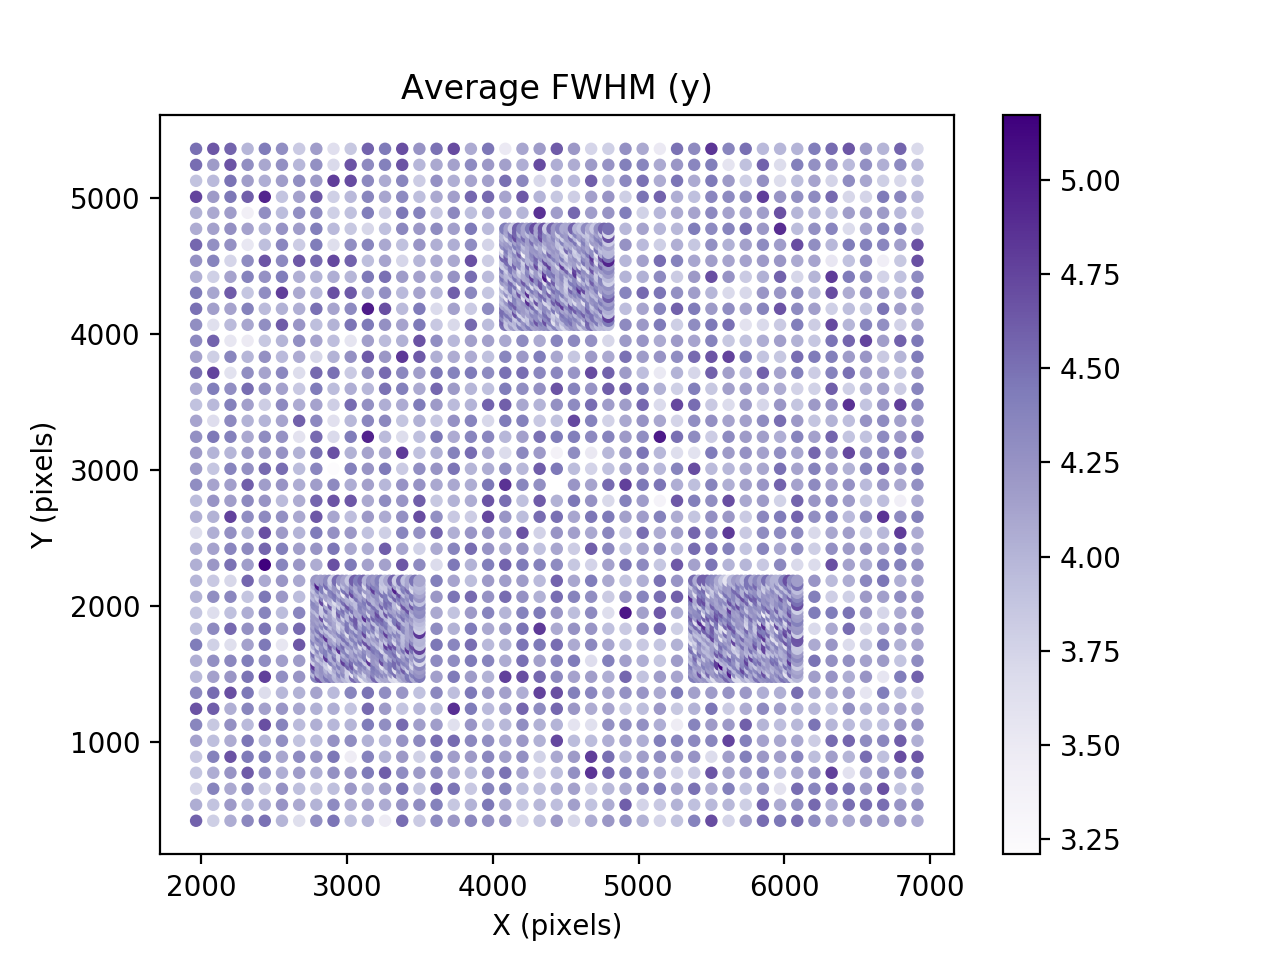

In [79]:
reload(viscalc)
reload(visplot)

plotrange=None
prefix=tag
visplot.plotVal(xAv,yAv,rmsVal,0,plotrange,"RMS (pixels)",prefix,"rms",'pixels')
visplot.plotVal(xAv,yAv,nMatch,0,plotrange,"Number of Points",prefix,"npoints",'pixels')
visplot.plotVal(xAv,yAv,fxAv,0,plotrange,"Average FWHM (x)",prefix,"_fwhmxav",'pixels')
visplot.plotVal(xAv,yAv,fyAv,10,plotrange,"Average FWHM (y)",prefix,"_fwhmyav",'pixels')



In [11]:
reload(viscalc)
reload(viscoords)
#get transformation by frame

xdAll,ydAll,sxAll,syAll,rotAll,fxFrameAv,fyFrameAv,peakFrameAv = viscalc.getTransByFrame(xArray,yArray,fxArray,fyArray,peakArray,xm,ym)


<IPython.core.display.Javascript object>


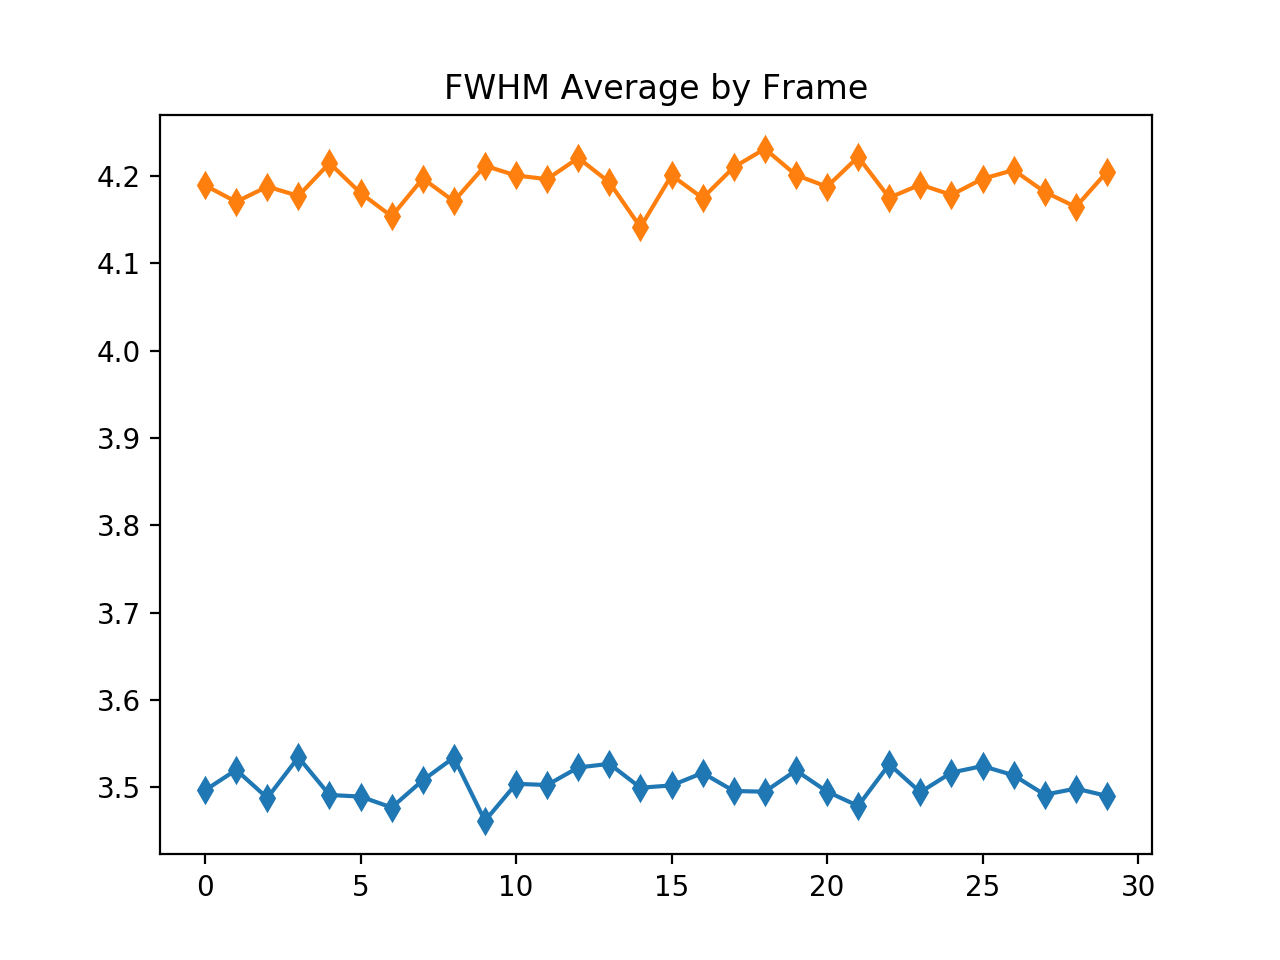

<IPython.core.display.Javascript object>


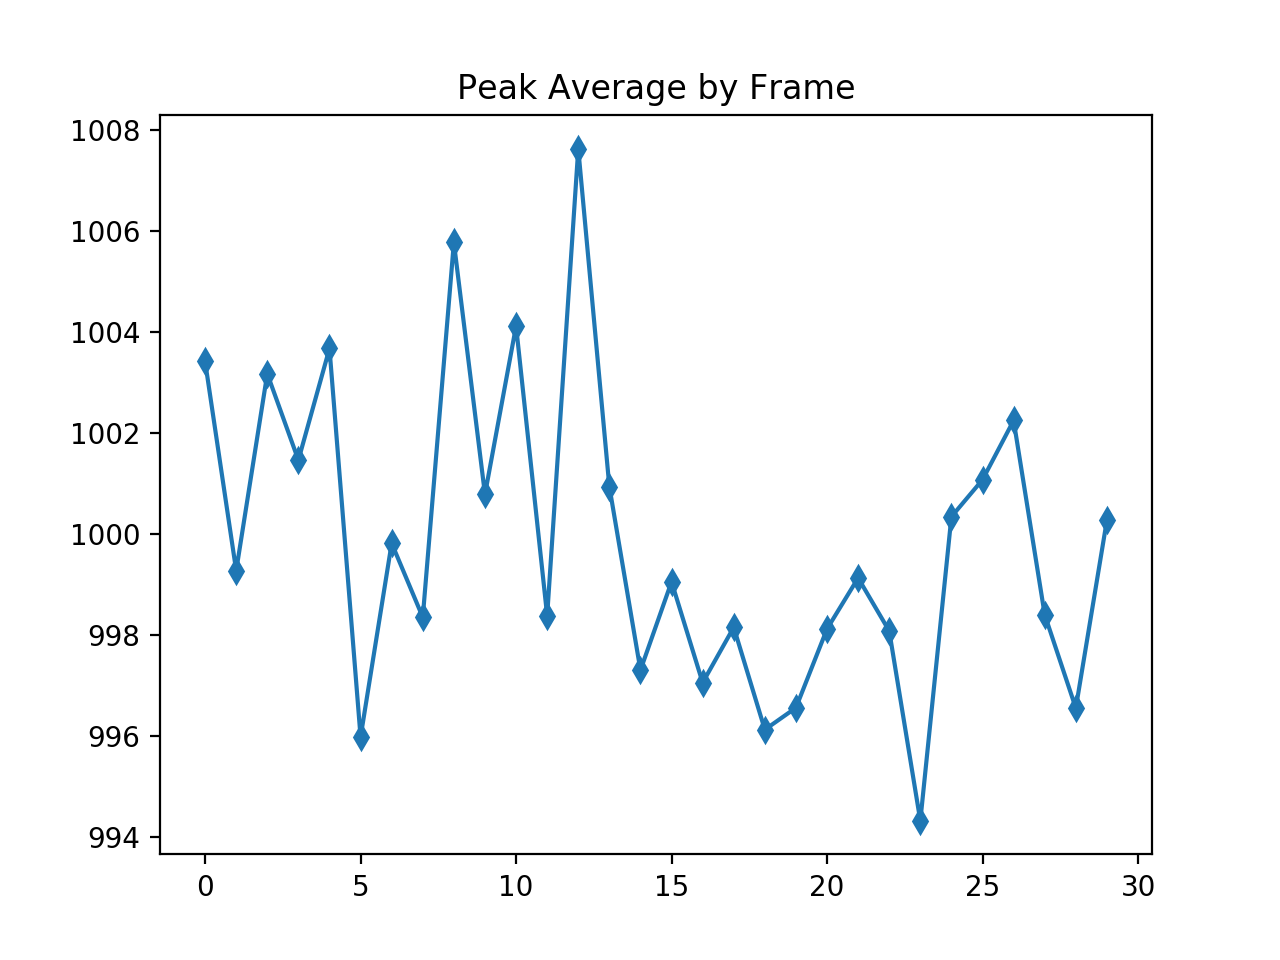

<IPython.core.display.Javascript object>


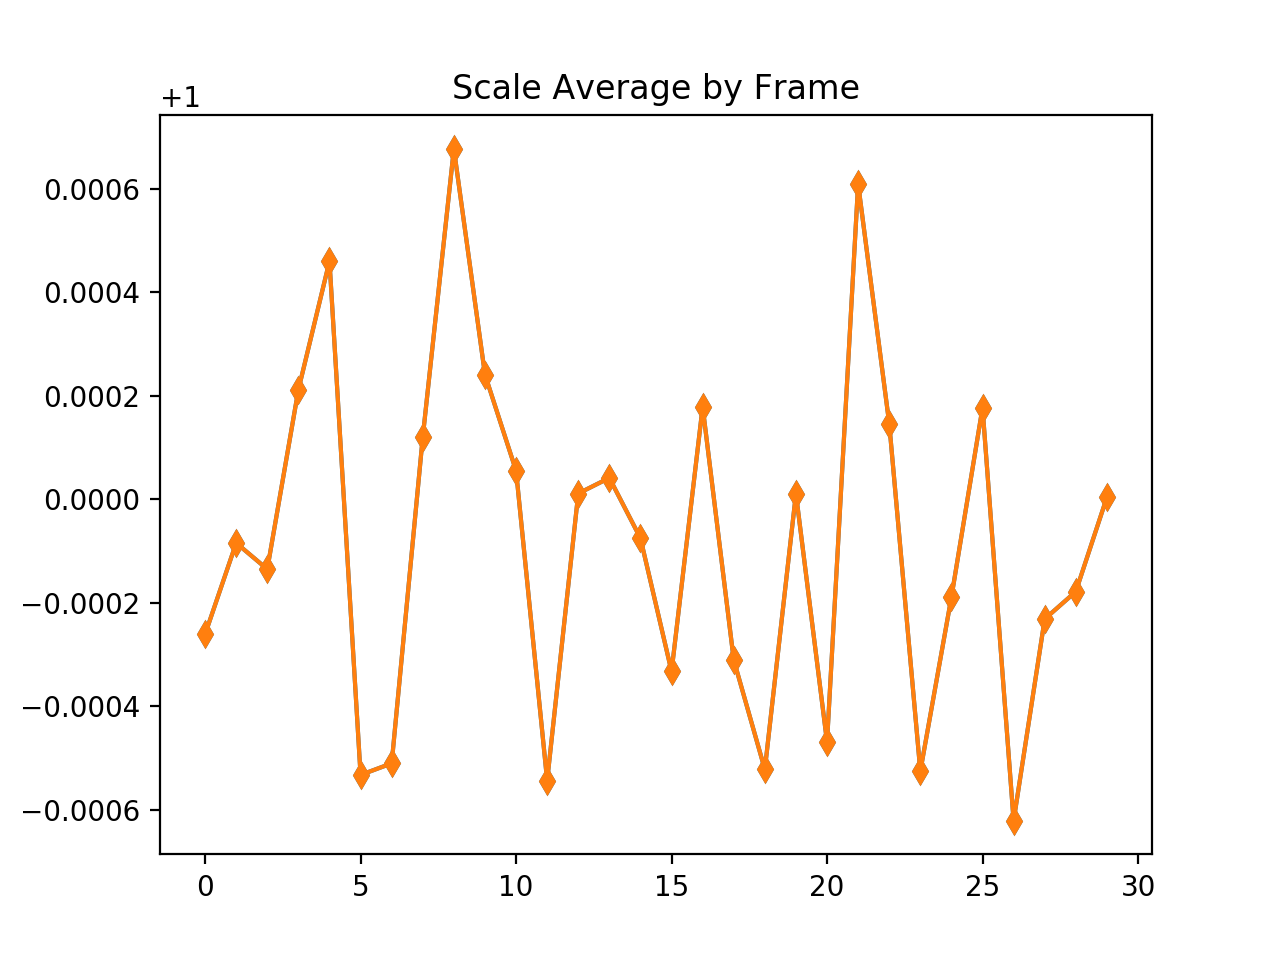

<IPython.core.display.Javascript object>


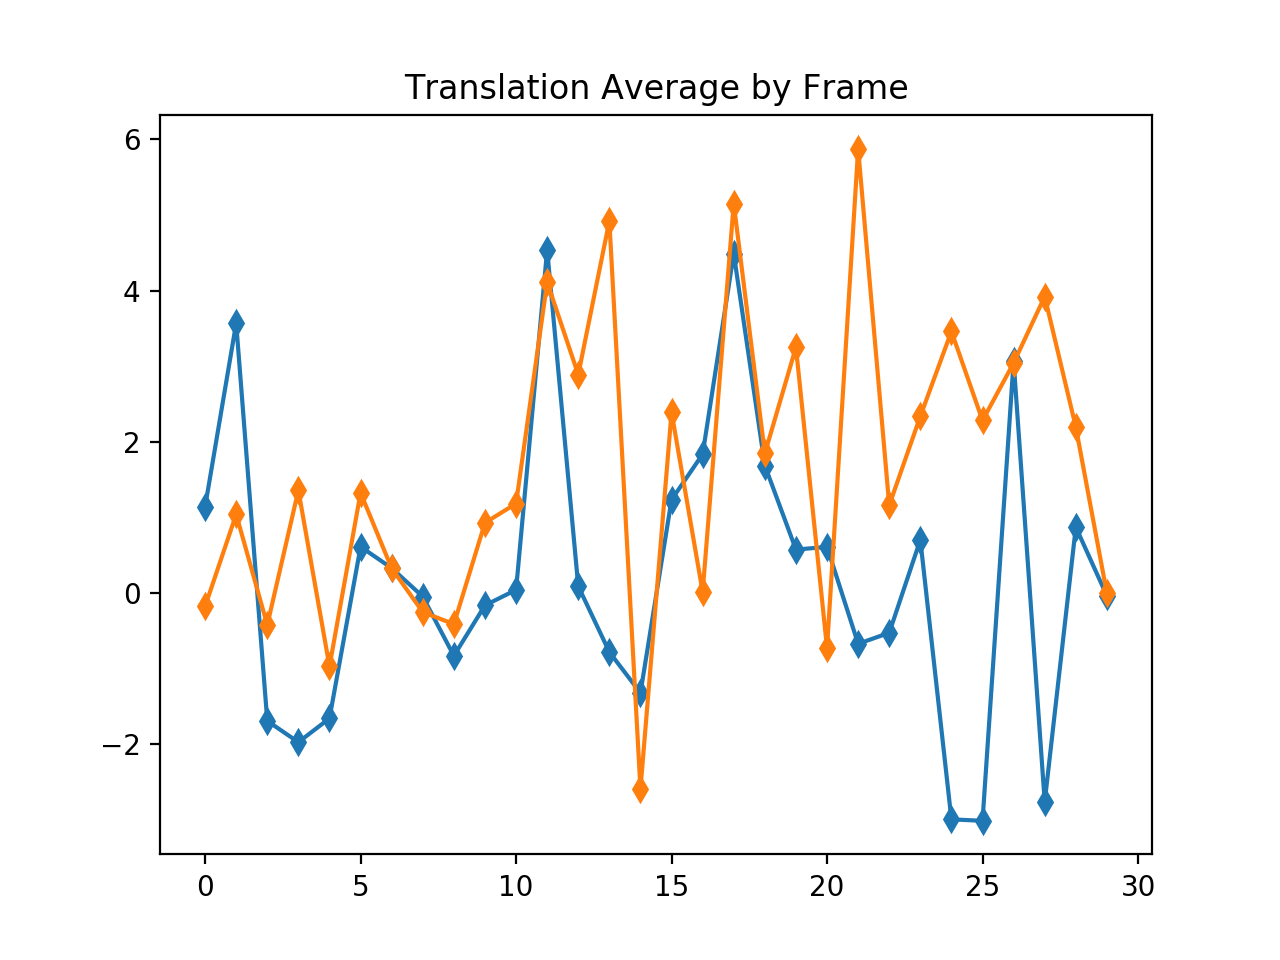

<IPython.core.display.Javascript object>


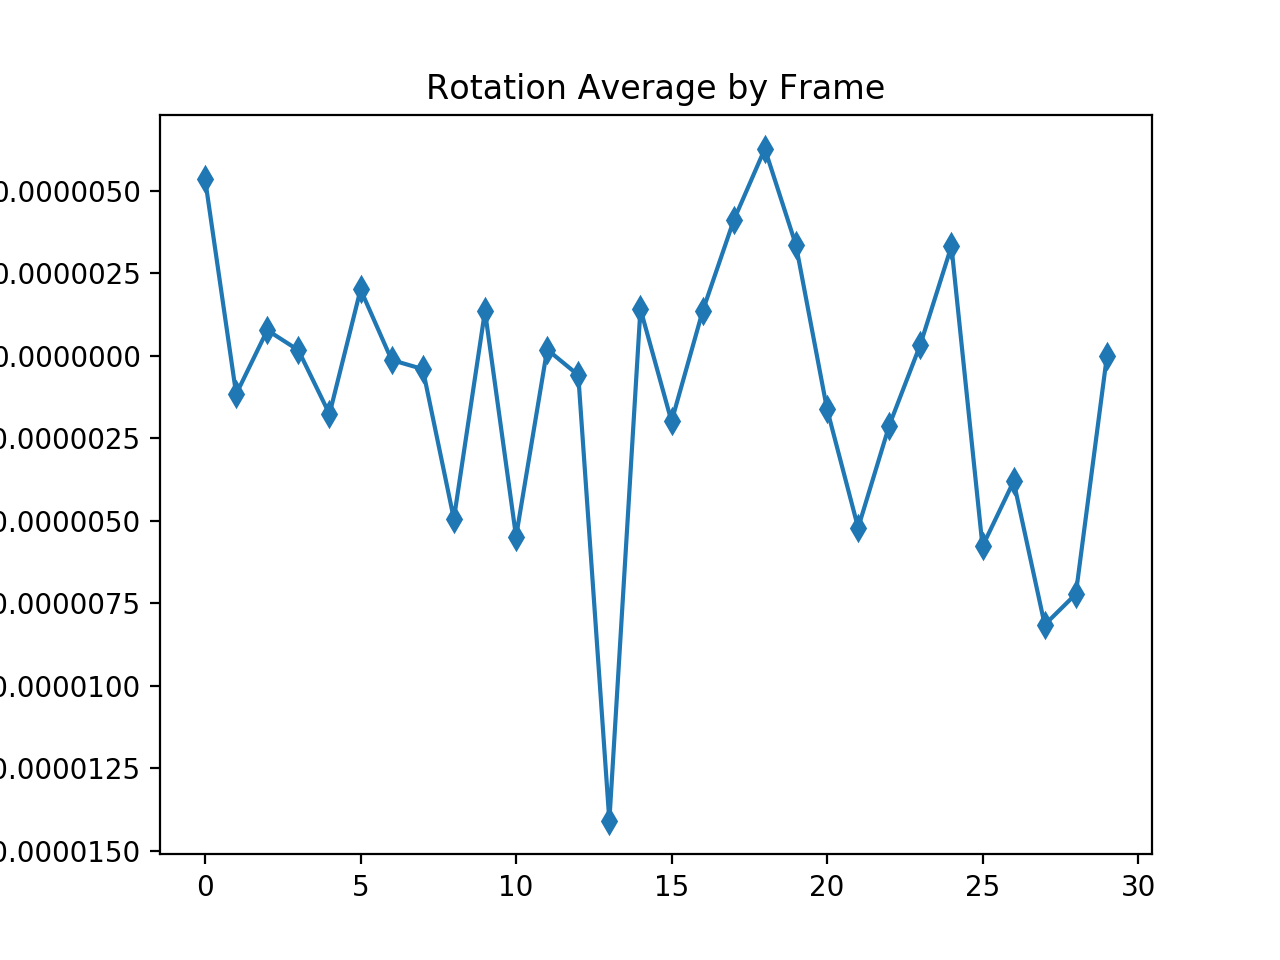

In [76]:

reload(visplot)
visplot.plotTransByFrame(fxFrameAv,fyFrameAv,peakFrameAv,sxAll,syAll,xdAll,ydAll,rotAll,prefix)

<IPython.core.display.Javascript object>


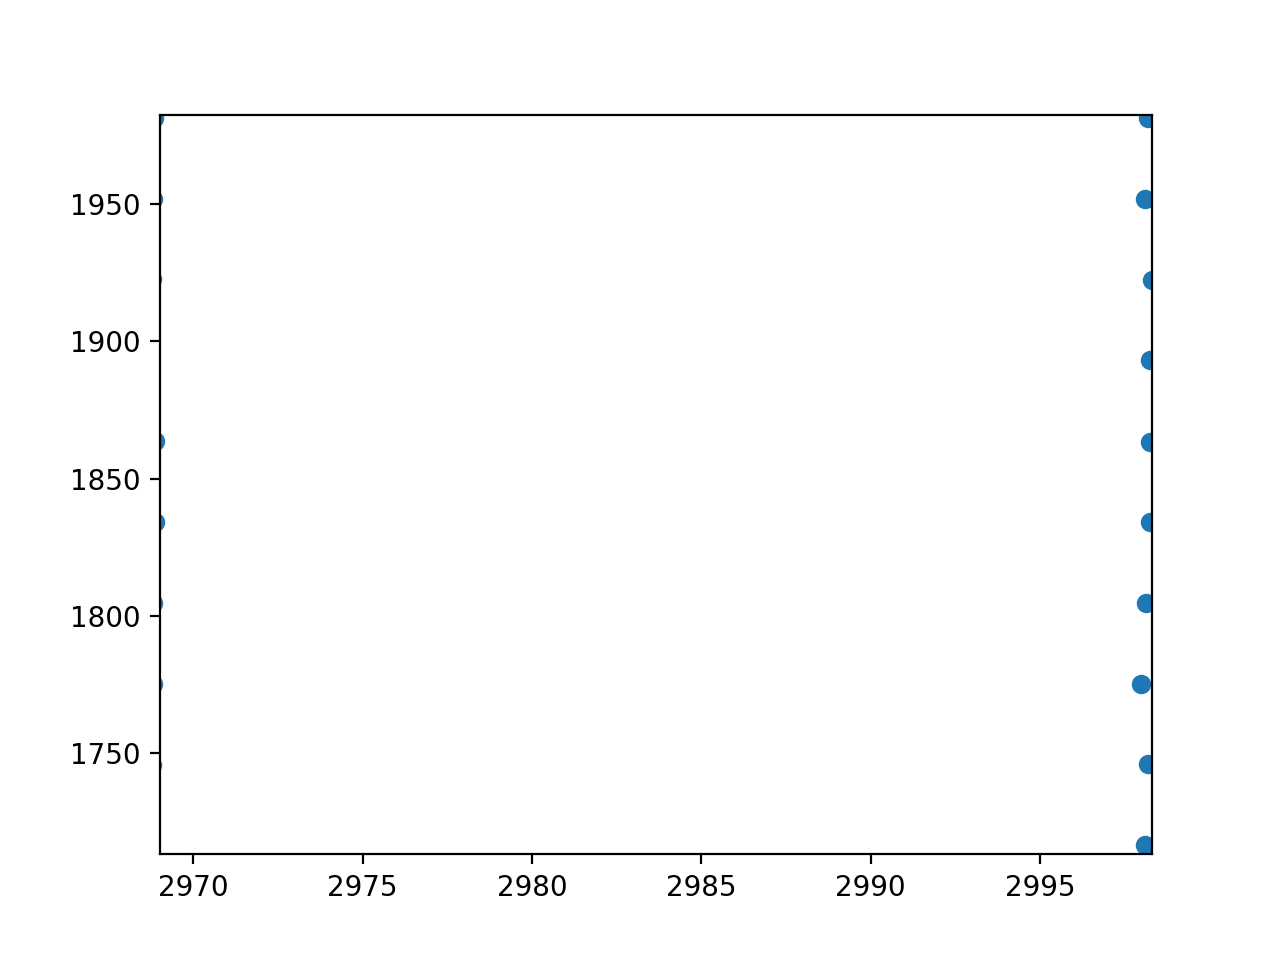